# Copyright Netherlands eScience Center <br>
** Function     : Lead/Lag regression of climatological fields on OMET with spatial patterns** <br>
** Author       : Yang Liu ** <br>
** First Built  : 2018.08.29 ** <br>
** Last Update  : 2019.01.02 ** <br>
Description     : This notebook includes the result of the lag regression of climatological fields (e.g. SST, SLP, z500) on OMET. It aims to unveil the relation between the climatological fields and OMET and try to illustrate how the ocean drives the atmosphere through the change of OMET.
Besides, the contribution of stationary eddy and steady mean transport are studied here too.<br>
Return Values   : jpeg <br>
Caveat          : The evaporation is not saved as output. We have to compute the evaporation with the following equation:<br>
Evaporation = Latent heat flux / Lv = W/m2 / J/kg = kg/m2s<br>
Then we need to change the unit to m/s, following the procedure below:<br>
1 kg of rain water spread over 1 square meter of surface is 1 mm in thickness.<br>
There are 60X60X24=86400 seconds in one day.<br>
Therefore, 1 kg/m2s = 86400 mm/day.<br>
Consequently, from kg/m2s to m/s:<br>
precipitation \* 86400 / (24\*3600) / 1000<br>

In [1]:
%matplotlib inline

import sys
sys.path.append("/home/ESLT0068/NLeSC/Computation_Modeling/Bjerknes/Scripts/META")
import numpy as np
import scipy
from netCDF4 import Dataset
import matplotlib
import matplotlib.pyplot as plt
import os
import meta.statistics
import meta.visualizer

import matplotlib.pyplot as plt
import matplotlib.path as mpath
import matplotlib.ticker as mticker
import iris
import iris.plot as iplt
import cartopy
import cartopy.crs as ccrs

Initialization - Start with location of input and extraction of variables
Time span of each product:
- **ERA-Interim** 1979 - 2016
- **MERRA2**      1980 - 2016
- **JRA55**       1979 - 2015
- **ORAS4**       1958 - 2014
- **GLORYS2V3**   1993 - 2014
- **SODA3**       1980 - 2015

In [2]:
# constants
constant = {'g' : 9.80616,      # gravititional acceleration [m / s2]
            'R' : 6371009,      # radius of the earth [m]
            'cp': 1004.64,      # heat capacity of air [J/(Kg*K)]
            'Lv': 2264670,      # Latent heat of vaporization [J/Kg]
            'R_dry' : 286.9,    # gas constant of dry air [J/(kg*K)]
            'R_vap' : 461.5,    # gas constant for water vapour [J/(kg*K)]
            'rho' : 1026,       # sea water density [kg/m3]
            'cw' : 3987,        # heat capacity of sea water [J/(Kg*K)]
            }

In [3]:
if __name__=="__main__":
    # sample
    ################################   Input zone  ######################################
    # specify data path
    datapath = '/home/ESLT0068/WorkFlow/Core_Database_AMET_OMET_reanalysis/warehouse_met'
    datapath_MERRA2_fields = '/home/ESLT0068/WorkFlow/Core_Database_AMET_OMET_reanalysis/MERRA2/regression'
    datapath_ORAS4_fields = '/home/ESLT0068/WorkFlow/Core_Database_AMET_OMET_reanalysis/ORAS4/regression'
    datapath_ORAS4_mask = '/home/ESLT0068/WorkFlow/Core_Database_AMET_OMET_reanalysis/ORAS4'
    output_path = '/home/ESLT0068/NLeSC/PhD/Paperwork/Article/MET_Feedback/figures/revision'
    #####################################################################################
    print ('*********************** extract variables *************************')
    dataset_MERRA2_flux = Dataset(os.path.join(datapath_MERRA2_fields,
                                  'surface_merra_monthly_regress_1980_2017_SFlux_Rad.nc'))
    dataset_MERRA2_prec = Dataset(os.path.join(datapath_MERRA2_fields,
                                  'surface_merra_monthly_regress_1980_2017_prec.nc'))
    dataset_ORAS4_OMET = Dataset(os.path.join(datapath,
                                 'oras_model_monthly_1958_2017_omet.nc'))
    dataset_ORAS4_mask = Dataset(os.path.join(datapath_ORAS4_mask, 'mesh_mask.nc'))
    dataset_MERRA2_mask = Dataset(os.path.join(datapath_MERRA2_fields,
                                  'surface_MERRA2_monthly_regress_1980_2016.nc'))
    # extract time series from 1979 to 2016
    # from 20N - 90N
    # 4D fields [year, month, lat, lon]
    # precipitation
    prec_MERRA2 = dataset_MERRA2_prec.variables['prec'][:-1,:,::-1,:] # unit m
    # flux
    rad_short_toa_MERRA2 = dataset_MERRA2_flux.variables['SWTNT'][:-1,:,:,:]
    rad_long_toa_MERRA2 = dataset_MERRA2_flux.variables['LWTUP'][:-1,:,:,:]
    rad_short_surf_MERRA2 = dataset_MERRA2_flux.variables['SWGNT'][:-1,:,:,:]
    rad_long_surf_MERRA2 = dataset_MERRA2_flux.variables['LWGNT'][:-1,:,:,:]
    SFlux_sensible_MERRA2 = dataset_MERRA2_flux.variables['HFLUX'][:-1,:,:,:]
    SFlux_latent_MERRA2 = dataset_MERRA2_flux.variables['EFLUX'][:-1,:,:,:]
    # evaporation
    evap_MERRA2 = SFlux_latent_MERRA2 / constant['Lv'] * 86400 / (24*3600) / 1000
    # calculate total net energy flux at TOA/surface
    # merra - watch out! the sign
    # reverse the meridional coordinate of MERRA2 for the sake of the calc. of residual
    net_flux_surf_MERRA2 = rad_short_surf_MERRA2[:,:,::-1,:] + rad_long_surf_MERRA2[:,:,::-1,:] -\
                           SFlux_sensible_MERRA2[:,:,::-1,:] - SFlux_latent_MERRA2[:,:,::-1,:]
    net_flux_toa_MERRA2 = rad_short_toa_MERRA2[:,:,::-1,:] - rad_long_toa_MERRA2[:,:,::-1,:]
    del rad_short_toa_MERRA2, rad_long_toa_MERRA2, rad_short_surf_MERRA2, rad_long_surf_MERRA2
    del SFlux_sensible_MERRA2, SFlux_latent_MERRA2

    # landsea mask JRA55
    SST_MERRA2 = dataset_MERRA2_mask.variables['SST_water'][0,0,::-1,:]
    mask_MERRA2 = np.zeros(SST_MERRA2.shape,dtype=int)
    mask_MERRA2[SST_MERRA2>1000] = 1
    
    # 3D fields [year, month, lat]
    OMET_int_ORAS4 = dataset_ORAS4_OMET.variables['E_int'][21:-1,:,180:]/1000 # from Tera Watt to Peta Watt # start from 1979
    OMET_atl_int_ORAS4 = dataset_ORAS4_OMET.variables['E_atl_int'][21:-1,:,180:]/1000
    
    OMET_pac_int_ORAS4 = dataset_ORAS4_OMET.variables['E_pac_int'][21:-1,:,180:]/1000  
    # other dimensions
    year_ORAS4 = dataset_ORAS4_OMET.variables['year'][21:-1]    # from 1979 to 2016
    latitude_OMET_ORAS4 = dataset_ORAS4_OMET.variables['latitude_aux'][180:]
    gphiv_OMET_ORAS4 = dataset_ORAS4_OMET.variables['gphiv'][180:,:]
    glamv_OMET_ORAS4 = dataset_ORAS4_OMET.variables['glamv'][180:,:]
    latitude_fields_MERRA2 = dataset_MERRA2_flux.variables['latitude'][::-1]
    longitude_fields_MERRA2 = dataset_MERRA2_flux.variables['longitude'][:]
    mask_ORAS4 = dataset_ORAS4_mask.variables['vmask'][0,0,180:,:]
    # area weighted surface flux
    net_flux_surf_MERRA2_area = np.zeros(net_flux_surf_MERRA2.shape, dtype=float) # unit W
    prec_MERRA2_area = np.zeros(prec_MERRA2.shape, dtype=float)
    evap_MERRA2_area = np.zeros(evap_MERRA2.shape, dtype=float)
    #evapor_ERAI_area = np.zeros(SFlux_latent_ERAI.shape, dtype=float)
    #net_flux_toa_ERAI_area = np.zeros(net_flux_toa_ERAI.shape, dtype=float)
    #size of the grid box
    dx = 2 * np.pi * constant['R'] * np.cos(2 * np.pi * latitude_fields_MERRA2 /
                                            360) / len(longitude_fields_MERRA2) 
    dy = np.pi * constant['R'] / len(latitude_fields_MERRA2)
    for i in np.arange(len(latitude_fields_MERRA2)):
        # change the unit to terawatt
        net_flux_surf_MERRA2_area[:,:,i,:] = net_flux_surf_MERRA2[:,:,i,:]* dx[i] * dy / 1E+12
        prec_MERRA2_area[:,:,i,:] = prec_MERRA2[:,:,i,:]* dx[i] * dy
        evap_MERRA2_area[:,:,i,:] = evap_MERRA2[:,:,i,:]* dx[i] * dy
        #evapor_ERAI_area[:,:,i,:] = SFlux_latent_ERAI[:,:,i,:] * dx[i] * dy / constant['Lv']

*********************** extract variables *************************


In [7]:
    #print (latitude_OMET_ORAS4[53])
    print(latitude_fields_MERRA2[:142])
    #print(OMET_atl_int_ORAS4)
    print(mask_MERRA2)
    print (prec_MERRA2_area[15,5,100:110,200:210])
    print('===================================')
    print (evap_MERRA2_area[15,5,100:110,200:210])
    #print (evapor_ERAI_area[15,5,100:110,200:210]/1026)

[90.  89.5 89.  88.5 88.  87.5 87.  86.5 86.  85.5 85.  84.5 84.  83.5
 83.  82.5 82.  81.5 81.  80.5 80.  79.5 79.  78.5 78.  77.5 77.  76.5
 76.  75.5 75.  74.5 74.  73.5 73.  72.5 72.  71.5 71.  70.5 70.  69.5
 69.  68.5 68.  67.5 67.  66.5 66.  65.5 65.  64.5 64.  63.5 63.  62.5
 62.  61.5 61.  60.5 60.  59.5 59.  58.5 58.  57.5 57.  56.5 56.  55.5
 55.  54.5 54.  53.5 53.  52.5 52.  51.5 51.  50.5 50.  49.5 49.  48.5
 48.  47.5 47.  46.5 46.  45.5 45.  44.5 44.  43.5 43.  42.5 42.  41.5
 41.  40.5 40.  39.5 39.  38.5 38.  37.5 37.  36.5 36.  35.5 35.  34.5
 34.  33.5 33.  32.5 32.  31.5 31.  30.5 30.  29.5 29.  28.5 28.  27.5
 27.  26.5 26.  25.5 25.  24.5 24.  23.5 23.  22.5 22.  21.5 21.  20.5
 20.  19.5]
[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [1 1 1 ... 1 1 1]
 [1 1 1 ... 1 1 1]
 [1 1 1 ... 1 1 1]]
[[ 55.4011998   50.31430988  48.51357641  45.26011771  44.47893402
   44.73886774  49.22355256  54.46494339  58.0864102   63.0025953 ]
 [ 46.67473844  43.8635

In [ ]:
    print ('*******************  quantify the autocorrelation  *********************')
    print ('===================  OMET + atl + 60N + full year  =====================')
    # account for the autocorrelation
    stat_OMET_ORAS4 = meta.statistics.operator(OMET_atl_int_ORAS4[1:,:,53])
    stat_OMET_ORAS4.anomaly()
    stat_OMET_ORAS4.detrend()
    auto_corr_OMET = meta.statistics.operator.autoCorr(stat_OMET_ORAS4._detrend)
    fig = plt.figure()
    plt.plot(auto_corr_OMET[:30])
    plt.plot(auto_corr_OMET[:30], 'ro')
    plt.show()
    fig.savefig(os.path.join(output_path,'autoCorr_OMET_fullyear.png'), dpi=300)
    print(auto_corr_OMET[:10])

# Buoyancy force <br>
**Ocean respond to the changes in atmosphere through the changes in the buoyancy force in shallow layers. The buoyancy flux has two components: a thermal forcing and a saline forcing. Thermal forcing comes from surface heat flux, while saline forcing comes from fresh water due to precipitation. ** <br>

The equation of buoyancy forcing can be shown as:<br>
$$ B = \frac{g\alpha}{c_w}(Q_s) + gS\beta (P-E)$$ 

Where the first part denotes thermal forcing and the second part is saline forcing. $\alpha$ and $\beta$ are the thermal and saline expansion coefficient. S is the surface salinity.<br> For the calculation here, we take $\alpha = 250 \times 10^{-6} K^{-1}$ (when $S=35g/kg,T=20 ^\circ C, pressure=0.1 MN/m^2$, and $\beta = 7.5 \times 10^{-4} psu^{-1})$ (this is the case when $S=35psu,T=15 ^\circ C,\alpha=26kg/m^3$, with $\alpha$ the density anomaly $\rho-\rho_{ref}$)and the mean surface salinity in the midlatitudes of North Atlantic $S=35 psu$.

Evaporation can be calculated from latent heat flux:<br>
$$ E = Q_l/L_v $$ 

with $ Q_l $ the latent heat flux and $ L_v $ the Latent heat of vaporization.<br> Be cautious that the latent heat flux given by ERA-Interim has the unit $W/m^2$. So the equation is actually:<br>
$$ E = Q_l/(L_v \times \rho) $$ 

Since E is also a function of $\rho$, in this case we will use the evaporation from model directly.<br>

The definition of buoyancy force can be found in Sathiyamoorthy and Moore, 2001. Buoyancy Flux at Ocean Weather Station Bravo. <br>


***********!@#$%^&*     Lead/ Lag regression of ORAS4   !@#$%^&***********
===================   OMET + atl + 60N & total SFlux +=================
The input data has the dimension of month.
The output anomaly time series only contains one dimension for time!
The input data has the dimension of month.
The output anomaly time series only contains one dimension for time!
One time series is regressed on a 2D field.
One time series is regressed on a 2D field.
Create a NorthPolarStereo view of input fields.
The input fields are originally on geographical grid


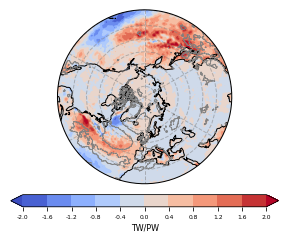

This boundary is not supported by the module. Please check the documentation.


In [19]:
    print ('***********!@#$%^&*     Lead/ Lag regression of ORAS4   !@#$%^&***********')
    print ('===================   OMET + atl + 60N & total SFlux +=================')
    stat_OMET_ORAS4 = meta.statistics.operator(OMET_atl_int_ORAS4[1:,:,53])
    stat_OMET_ORAS4.anomaly()
    stat_OMET_ORAS4.detrend()
    # by default, the running mean is taken with a window of 60 months
    stat_OMET_ORAS4.lowpass(window=120, obj='detrend')
    stat_SFlux_MERRA2 = meta.statistics.operator(net_flux_surf_MERRA2_area[:,:,:142,:])
    stat_SFlux_MERRA2.anomaly()
    stat_SFlux_MERRA2.detrend()
    stat_SFlux_MERRA2.lowpass(window=120, obj='detrend')
    lag = 0
    k, r, p = meta.statistics.operator.linearRegress(stat_OMET_ORAS4._lowpass,
                                                     stat_SFlux_MERRA2._lowpass, lag)
    # regression for t-test value based on real degree of freedom
    _, _, p_real = meta.statistics.operator.linearRegress(stat_OMET_ORAS4._detrend,
                                                          stat_SFlux_MERRA2._detrend, lag)
    #ticks = [-0.3, -0.2, -0.1, 0.0, 0.1, 0.2, 0.3]
    #ticks = [-0.5, -0.4, -0.3, -0.2, -0.1, 0.0, 0.1, 0.2, 0.3, 0.4, 0.5]
    #ticks = [-0.8, -0.6, -0.4, -0.2, 0.0, 0.2, 0.4, 0.6, 0.8]
    ticks = [i for i in np.linspace(-2.0,2.0,11)]
    #label = 'Correlation coefficient'
    label = 'TW/PW'
    meta.visualizer.plots.geograph(latitude_fields_MERRA2[:142], longitude_fields_MERRA2[:], k, p_real,
                                   label, ticks, os.path.join(output_path,
                                   'spatial_ORAS4_atl_OMET_60N_lag_{}_MERRA2_SFlux_decadal_area.png'.format(lag)),
                                   ttest='line')  

***********!@#$%^&*     Lead/ Lag regression of ORAS4   !@#$%^&***********
===================   OMET + atl + 60N & total buoyancy forcing   =================
The input data has the dimension of month.
The output anomaly time series only contains one dimension for time!
The input data has the dimension of month.
The output anomaly time series only contains one dimension for time!
One time series is regressed on a 2D field.
One time series is regressed on a 2D field.
Create a NorthPolarStereo view of input fields.
The input fields are originally on geographical grid


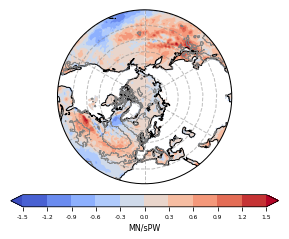

This boundary is not supported by the module. Please check the documentation.


In [4]:
    print ('***********!@#$%^&*     Lead/ Lag regression of ORAS4   !@#$%^&***********')
    print ('===================   OMET + atl + 60N & total buoyancy forcing   =================')
    # calculate buoyancy forcing
    # here we take mean surface salinity as a constant (35 psu)
    # the unit of buoyancy flux is Newton (N/s) as we apply the weight by area
    Buoyancy_F_saline = (prec_MERRA2_area + evap_MERRA2_area) * 35 * 7.5E-4 * constant['g'] * constant['rho'] # the sign of evapor is minus
    # convert Watt to Joule times 30*3600, while with unit N/s we need to devide 30*3600, so they cancel out
    Buoyancy_F_thermal = (net_flux_surf_MERRA2_area)* 1E+12 * 250E-6 * constant['g'] / constant['cw'] 
    Buoyancy_F = Buoyancy_F_saline + Buoyancy_F_thermal
    stat_OMET_ORAS4 = meta.statistics.operator(OMET_atl_int_ORAS4[1:,:,53])
    stat_OMET_ORAS4.anomaly()
    stat_OMET_ORAS4.detrend()
    # by default, the running mean is taken with a window of 60 months
    stat_OMET_ORAS4.lowpass(window=120, obj='detrend')
    stat_buoy_MERRA2 = meta.statistics.operator(Buoyancy_F[:,:,:142,:])
    stat_buoy_MERRA2.anomaly()
    stat_buoy_MERRA2.detrend()
    stat_buoy_MERRA2.lowpass(window=120, obj='detrend')
    lag = 0
    k, r, p = meta.statistics.operator.linearRegress(stat_OMET_ORAS4._lowpass,
                                                     stat_buoy_MERRA2._lowpass, lag)
    # regression for t-test value based on real degree of freedom
    _, _, p_real = meta.statistics.operator.linearRegress(stat_OMET_ORAS4._detrend,
                                                          stat_buoy_MERRA2._detrend, lag)
    # mask the significane value
    p_real[mask_MERRA2[:142,:]==1] = 1
    ticks = [i for i in np.linspace(-1.5,1.5,11)]
    #label = 'Correlation coefficient'
    label = 'MN/sPW'
    meta.visualizer.plots.geograph(latitude_fields_MERRA2[:142], longitude_fields_MERRA2[:],
                                   np.ma.masked_where(mask_MERRA2[:142,:]==1,k/1E+6), p_real,
                                   label, ticks, os.path.join(output_path, 
                                   'spatial_ORAS4_atl_OMET_60N_lag_{}_MERRA2_buoyF_decadal_area.png'.format(lag)),
                                   ttest='line')    